In [1]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  #'last', 'last_expr'

In [207]:
import sys
sys.path.insert(0, '/nas/xd/projects/transformers/src')
import os
os.environ['HF_HOME'] = '/raid3/xd/.cache/torch'  # deliberately set this wrong path to avoid migrating cache
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="8,7"

from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter
from datetime import datetime
from io import StringIO
from dataclasses import dataclass, fields
import itertools
from itertools import chain
import math
from functools import reduce, partial
from collections.abc import Iterable
from collections import namedtuple 
import traceback
import pickle, gzip

# from multiprocessing import Pool
# from torch.multiprocessing import Pool
# torch.multiprocessing.set_start_method('spawn', force=True)
from multiprocessing.dummy import Pool

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

In [6]:
# from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, GPT2Tokenizer#, pipeline
# from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM
# from transformers import T5Tokenizer, T5TokenizerFast, T5ForConditionalGeneration
# from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed, AdamW

In file_utils.py: default_cache_path = /raid3/xd/.cache/torch/hub


In [7]:
sys.path.insert(0, '/nas/xd/projects/PyFunctional')
from functional import seq
from functional.pipeline import Sequence
from fn import _ as __

In [8]:
from common_utils import Timer
with Timer('common_utils'): from common_utils import *
with Timer('utils'): from utils import *
with Timer('child_utils'): from child_utils import *
from child_utils import _cxt2str, _item2str
with Timer('child_utils'): from child_frames import *
with Timer('model_utils'): from model_utils import *

common_utils ... done 0:00:00.000041
utils ... done 0:00:00.036111
child_utils ... path = /nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/site-packages/pattern/text/en/en-verbs.txt
done 0:00:10.981187
child_utils ... done 0:00:00.019491
model_utils ... In model_utils.py: finish import
done 0:00:24.076526


In [9]:
torch.set_grad_enabled(False);

In model_utils.py: finish import


In [10]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
# cache_dir = '/mnt/nvme1/xd/.cache/torch/transformers/'  # for gpt-j-6B on elderberry
proxies = {'http': '192.168.50.1:1081'} 

In [11]:
# curl -x http://192.168.50.1:1081 -L -O [-C -] https://huggingface.co/google/ul2/resolve/main/pytorch_model.bin  # -C for 断点续传
s2s_model_names = ['google/t5-xl-lm-adapt', 'google/t5-xxl-lm-adapt', 'bigscience/T0p', 'bigscience/T0_3B', 
    'allenai/tk-instruct-3b-pos', 'allenai/tk-instruct-3b-def-pos', 'google/ul2']
gpt_model_names = ['EleutherAI/gpt-j-6B/cpu', 'EleutherAI/gpt-neox-20b', 'EleutherAI/gpt-neox-20b/cpu']#, 'gpt2-xl', 'gpt2']
#                    'KoboldAI/fairseq-dense-6.7B', 'KoboldAI/fairseq-dense-13B']
for model_name in s2s_model_names[:0] + gpt_model_names[:1]:#, 'gpt2-xl', 'EleutherAI/gpt-neo-1.3B', 'KoboldAI/fairseq-dense-6.7B']:
    if model_name in models: continue
    with Timer(model_name):
        model_cls = AutoModelForCausalLM if any(s in model_name for s in ['gpt', 'fairseq-dense']) else T5ForConditionalGeneration
        # _cache_dir = cache_dir.replace('/nas/', '/nas2/') if 'gpt' not in model_name else cache_dir
        kwargs = dict(cache_dir=cache_dir, proxies=proxies, low_cpu_mem_usage=True)
        if '/cpu' in model_name or 'gpt-j' not in model_name and 'gpt-neox' not in model_name:
            model = model_cls.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir, proxies=proxies)
        elif 'gpt-j' in model_name:
            device = 1
            model = model_cls.from_pretrained(model_name, revision="float16", torch_dtype=torch.float16, **kwargs).to(device)
        elif 'gpt-neox' in model_name:
            device = 0; device_map = {'gpt_neox': device, 'embed_out': device}
            model = model_cls.from_pretrained(model_name, device_map=device_map, load_in_8bit=True, **kwargs)
        if hasattr(model.config, 'use_cache'): model.config.use_cache = False  # save GPU mem
        # if model_name in ['EleutherAI/gpt-neox-20b']: model = model.half()
        tokenizer = AutoTokenizer.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir)
        unify(model)
        models[model_name] = model, tokenizer#, device

EleutherAI/gpt-j-6B/cpu ... done 0:08:53.011342


In [597]:
import openai
openai.api_key = open('/nas/xd/projects/openai_api_keys.txt').readlines()[2].split()[0]
response = openai.Completion.create(engine='text-davinci-002', prompt='Once upon a time',
    max_tokens=20, echo=True, logprobs=5)
print(response.choices[0].text)

Once upon a time, there was a tribe of smart, resourceful people.

This tribe lived in a land


In [10]:
def get_openai_model(engine):
    def forward(input_ids):#, attention_mask=None):
        text = tokenizer.decode(input_ids[0])
        response = openai.Completion.create(engine=engine, prompt=text, max_tokens=0, echo=True, logprobs=5)
        return Outputs(logits=response.choices[0].logprobs)
    return forward
    
tokenizer0 = GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)
engines = ['text-babbage-001', 'text-curie-001', 'text-davinci-001', 'text-davinci-002'][1:] #+ \
#     ['curie', 'curie:2020-05-03', 'curie-instruct-beta', 'text-curie-001'] + \
#     ['davinci', 'davinci:2020-05-03', 'davinci-instruct-beta', 'davinci-instruct-beta:2.0.0', 'text-davinci-001', 'text-davinci-002']
for engine in engines: models[engine] = get_openai_model(engine), tokenizer0

In [13]:
model_name = gpt_model_names[0]
model, tokenizer = models[model_name]
unify(model)
if model_name == 'EleutherAI/gpt-neox-20b/' and model_name + '/cpu' in models:
    unify(models[model_name + '/cpu'][0])

blocks = model.transformer.h
attn0 = blocks[0].attn
ln_f = model.transformer.ln_f
L, H, embed_dim = len(blocks), attn0.num_heads, attn0.embed_dim

In [14]:
_girls = [name for name in girls if max(len(tokenizer.tokenize(name)), len(tokenizer.tokenize(' ' + name))) == 1]
_boys = [name for name in boys if max(len(tokenizer.tokenize(name)), len(tokenizer.tokenize(' ' + name))) == 1]
_boys = sample(_boys, len(_girls))
def persons(): return _boys + _girls

In [ ]:
# I = Identity; M = Mophism; A = Aggregation; C = CMP; G = GroupBy; l = local
patterns = ['M', 'A?', 'IA', 'MA',
    'IlI', 'MlI', 'IlM', 'MlM', 'IlMlI',
    'IlA', 'MlA', 'IlC', 'MlC', 'AlI', 'GIlI']
# NE types: boy girl planet letter number month day
# TreeSet(name_genders), TreeSet(name_prons), # resolve iu in speech,  item[0]
# BijectSet(place_landmarks), BijectSet(sport_players) # count, item[1]

In [16]:
def ith_gen(rels, cxt_len=3):
    hop = 0; cxt = sample(rels[hop][0].codom(), cxt_len)
    query, candidates, ans = None, (cxt, cxt), cxt[1]
    return cxt, query, candidates, ans

In [30]:
tasks = [
    # (lambda: [[EqSet(uppercase).equal], ], ith_gen, partial(_cxt2str, sep=' '), lambda q, _: '', 'Ġ->'), 
    (lambda: [[TreeSet(types_of_things).child], [EqSet(persons).equal]], g2c(MlM_gen),
        partial(_cxt2str, sep='. ', item2str=lambda item, vocab: f"The {item[0]} is {item[1]}'s"),
        # lambda query, vocab: f'So does the {query[0]} belong to {query[1]}',
        lambda query, vocab: f'{query[0]} {query[1]}'#f"So is the {query[0]} {query[1]}'s",
    ), 
    (lambda: [[TreeSet(types_of_things).child], [EqSet(persons).equal]], MlM_gen,
     # partial(_cxt2str, prefix='There are ', item2str=lambda i, _: f"{i[1]}'s {i[0]}"), lambda q, _: f"So whose {q}", '?' # worse 
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f"The {i[0]} is {i[1]}'s"), lambda q, _: f'So the {q} belongs', 'Ġto'
    ),
    (lambda: [[EqSet(persons).equal], [TreeSet(types_of_things).parent]], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} has {add_a_or_an(i[1])}'), lambda q, _: f'{q}', "'s"
    ), # t: 21-5, 15-8, 19. p: 16-7, 18-5, [3-12, 13-7]. p+: 16-7, 16-0. 13-7:induction head qk, thing->type ov
    (lambda: [EqSet(persons).use('equal'), TreeSet(types_of_things).use('equal')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} has {wrap_noun(i[1])}'), lambda q, _: f'{q}', "'s"
    ),
    (lambda: [EqSet(persons).use('equal'), TreeSet(types_of_things).use('parent')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f"{i[0]} has {wrap_noun(i[1])}"), lambda q, _: f'{q}', "'s"
    #  partial(_cxt2str, sep='. ', item2str=lambda i, _: f"{i[0]}'s {i[1]}"), lambda q, _: f'{q}', "'s"
    ),
#     (lambda: [[EqSet(persons).equal], [SymSet(person_adjs).opposite]], g2c(MlM_gen),
#      partial(cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} is {i[1]}'), lambda q, _: f'So is {q[0]} {q[1]}', '?'
#     ), # c << g. cxt_len=3->2, gpt-j/neox better, davinci-001/002 worse!?
#     (lambda: [[EqSet(persons).equal], [SymSet(person_adjs).opposite]], MlM_gen,
#      partial(cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} is {i[1]}'), lambda q, _: f'So {q} is', 'Ġnot'
#     ), # verbose acc: gpj-j > curie-001 > davinci-001 > gpt-neox!? abstract acc: gpt-neox > gpt-j. all poor (inc. davinci-002!)
#     (lambda: [[SymSet(person_adjs).equal], [EqSet(persons).equal]], MlM_gen,
#      partial(cxt2str, item2str=lambda i, _: f'{i[1]} is {i[0]}'), lambda q, _: f'So who is {}', '?'
#     ),  # gpt-neox good
#     (lambda: [[EqSet(persons).equal], [SymSet(person_adjs).equal]], MlM_gen,
#      partial(cxt2str, prefix='There are ', item2str=lambda i, _: f'{i[1]} {i[0]}'), lambda q, _: f'So {q}', 'Ġis'
#     ),
# #     (lambda: [[EqSet(persons).equal], [PoSet(digits).equal], [EqSet(persons).equal]], g2c(IlMlI_gen),
# #         partial(cxt2str, item2str=lambda item, vocab: f'{item[0]} {item[1]}'),
# #         lambda query, vocab: f'{query[0]} and {query[1]} are same?'
# #     ),
# #     (lambda: [[EqSet(persons).equal], [PoSet(digits).equal], [EqSet(persons).equal]], lMlI_gen,
# #         partial(cxt2str, item2str=lambda item, vocab: f'{item[0]} is {item[1]}'),
# #         lambda query, vocab: f'{query} is the same as', # bare query is better for gpt-neox!?
# #     ),
#     (lambda: [[EqSet(persons).equal], [BijectSet(capabilities).proj]], partial(MlM_gen, cxt_len=2),
#      partial(cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} has {add_a_or_an(i[1])}'), lambda q, _: f'So {q}', 'Ġcan'
#     ),  # even davinci-001 is not very good
#     (lambda: [[EqSet(persons).equal], [BijectSet([(vt.did, vt.does) for vt in verb_tenses]).proj]], MlM_gen,
#      partial(cxt2str, sep='. '), lambda q, _: f'{q}', 'Ġusually'
#     ), # best performance among all tasks by all models. abstract > verbose
#     (lambda: [[EqSet(persons).equal], [BijectSet(country2capital).inv_proj]], MlM_gen,
#      partial(cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} lives in {i[1]}'), lambda q, _: f'{q} is', 'Ġfrom'
#     ),
#     (lambda: [[EqSet(persons).equal], [BijectSet(city2resident).proj]], MlM_gen,
#      partial(cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} lives in {i[1]}'), lambda q, _: f'{q}', 'Ġis'
#     ), # a little worse than capital -> country
]

In [128]:
results = {}; key = None

In [222]:
with gzip.open(f'results.pkl.gz', 'wb') as f:
    pickle.dump({k: result2dict(r) for k, r in results.items()}, f)
# with gzip.open(f'results.pkl.gz', 'rb') as f:
#     results = pickle.load(f)

In [56]:
attn_patterns_by_step = {-1: ['bos->ans0]'], 0: ['bos->ans]'], 1: ['ans]->ans0]', 'ans]->ans0+']}

In [221]:
def result2dict(result):
    return {k: v for k, v in result.__dict__.items() if k not in ['task', 'data_tuples']}

In [204]:
nrows, k_shot = 8, 3
for task, cxt_len, abstract, do_g2c in tqdm(list(itertools.product(tasks[-2:], [1, 2], [0, 1], [False, ]))):
    seed(42)
    args = dict(cxt_len=cxt_len, abstract=abstract)
    if do_g2c: args['do_g2c'] = do_g2c
    res_key = f"{task2str(task)} ({', '.join(f'{k}={v}' for k, v in args.items())})"
    if do_g2c and not ('TreeSet.parent' in res_key and cxt_len == 2 and abstract == 0): continue
    if key is not None and res_key != key: continue
    if res_key in results:
        result = results[res_key]; data_tuples = result.data_tuples
    else:
        batch_size = 4; verbose = batch_size <= 4
        if verbose: print(f'===== {res_key} =====')
        all_examples, texts, bos_tokens = zip(*[generate(task, verbose=False, plot=False, nrows=nrows, **args)
                                                for i in range(batch_size)])
        result = Result(task, args, all_examples, texts)

        data_tuples, eval_results = zip(*[predict(model, tokenizer, text, examples,
            k_shot=k_shot, bos_token=bos_tokens[0], verbose=verbose)
            for text, examples in zip(texts, all_examples)])
        result.data_tuples = data_tuples
        loss, acc, *_ = zip(*eval_results)
        result.mean_loss, result.mean_acc = np.array(loss).mean(), np.array(join_lists(acc)).mean()
        results[res_key] = result

    for node_name in ['node']:#, 'argmax_node']:
        node = getattr(result, node_name, None)
        if node is None: node = add_node_to_result(result, node_name=node_name, label_type=node_name.replace('node', 'labels'))
        node.data.attr = mr(attribute_step)(data_tuples[:4], model, node)
    result.node.data.scores = {ap: mr(get_head_matching_scores)(data_tuples, ap, k_shot=k_shot)
        for ap in attn_patterns_by_step[node.data.step]} if 'g2c' not in res_key else None

100%|██████████| 8/8 [00:12<00:00,  1.55s/it]


In [123]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=1, abstract=0): 0.032, 1.0
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=1, abstract=1): 0.117, 0.90625
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0): 0.594, 0.65625
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=1): 1.354, 0.53125
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=0): 0.793, 0.625
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=1): 0.286, 0.8125
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0): 2.174, 0.46875
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=1): 1.824, 0.46875


London has a burger. London's food
Jamie has a pizza. Jamie's food
Joy has a pistol. Joy's weapon
 [-1] root labels┐
                 └[0] top[0, 3, 4] 20-5,15-8,21-5 attn_labels┐
                                                             └[1] top[0, 1] 8-1,12-10┐
                                                                                     └*[2] top[0, 1] 5-12,7-2...
[-1] root labels


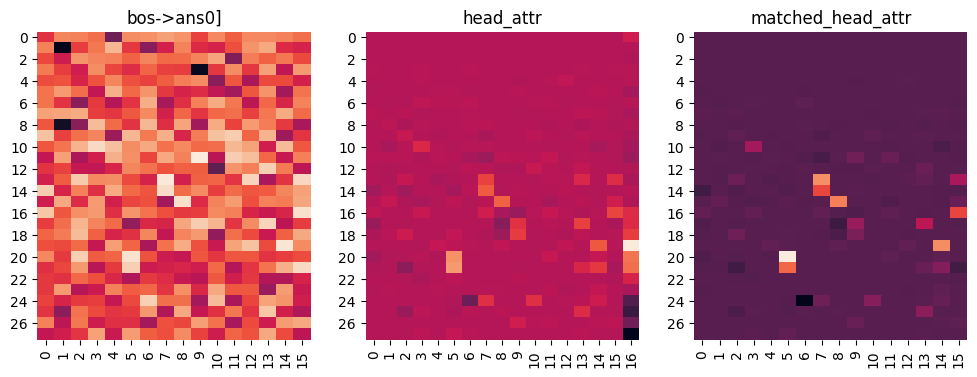

(array([11, 13, 19, 20, 16, 15, 14, 10, 21, 13]),
 array([ 9,  7, 14,  5, 15,  8,  7,  3, 15, 15]),
 array([-0.4349876, -0.5271155, -0.6725031, -0.7400898, -0.7721441,
       -0.7932828, -0.9576964, -1.026036 , -1.0345848, -1.0595406],
      dtype=float32))
(array([19, 21, 20, 20, 21, 15, 14, 19, 16, 13]),
 array([16,  5,  5, 16, 16,  8,  7, 14, 15,  7]),
 array([1.651996  , 1.029985  , 0.96665406, 0.78627765, 0.7544155 ,
       0.67617255, 0.62602866, 0.6084214 , 0.5003369 , 0.4799834 ],
      dtype=float32))
(array([20, 13, 19, 15, 21, 14, 16, 17, 13, 10]),
 array([ 5,  7, 14,  8,  5,  7, 15, 13, 15,  3]),
 array([1.3061308 , 0.9105848 , 0.9047116 , 0.85237265, 0.7648076 ,
       0.65368176, 0.64798385, 0.40298358, 0.3184108 , 0.2960562 ],
      dtype=float32))
[0] top[0, 3, 4] 20-5,15-8,21-5 attn_labels


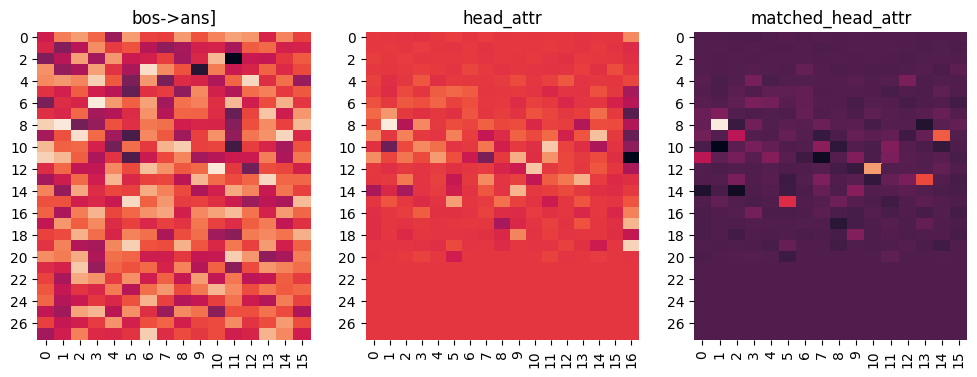

(array([ 6,  8, 12,  9,  3, 15, 13,  4,  9, 11]),
 array([ 3,  1, 10,  2,  6,  5, 13, 12, 14,  0]),
 array([-2.0047698, -2.0751946, -2.0947797, -2.3899155, -2.4032595,
       -2.5390391, -2.571194 , -2.5823462, -2.6415858, -2.7976642],
      dtype=float32))
(array([ 8, 19, 10, 12,  9, 14, 17, 13, 11, 15]),
 array([ 1, 16, 11, 10, 14,  9, 16, 13,  9,  5]),
 array([0.9747391 , 0.82241213, 0.7610413 , 0.7319919 , 0.7036818 ,
       0.64335304, 0.6406404 , 0.6252868 , 0.5944871 , 0.51662207],
      dtype=float32))
(array([ 8, 12,  9, 13, 15, 11,  9, 10, 14, 11]),
 array([ 1, 10, 14, 13,  5,  0,  2,  7,  9,  4]),
 array([0.46970972, 0.34943622, 0.26638612, 0.24318929, 0.20347148,
       0.15300176, 0.15045455, 0.08416142, 0.07752506, 0.07396084],
      dtype=float32))
[1] top[0, 1] 8-1,12-10


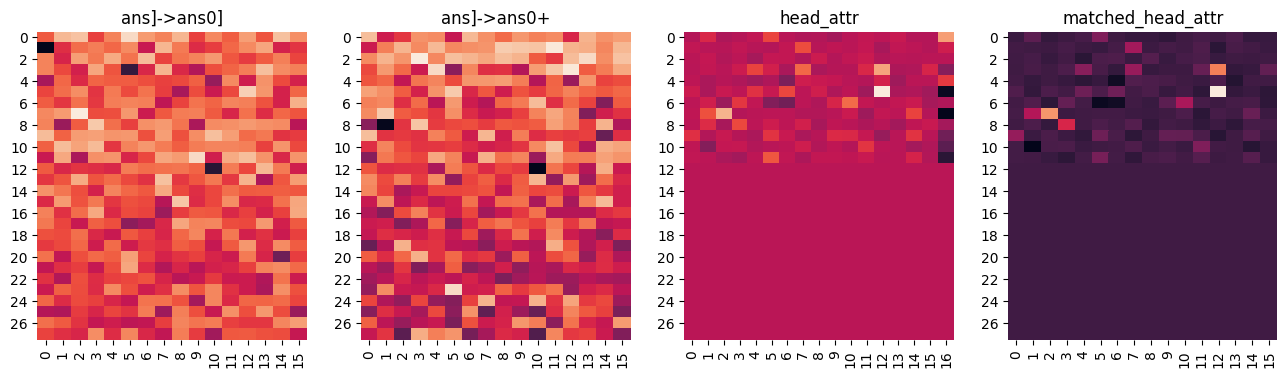

(array([ 7,  0, 11,  5,  8, 15,  0, 13,  0,  9]),
 array([ 2,  5,  9, 12,  3,  8,  2,  7, 14, 10]),
 array([-0.3700801 , -0.91300535, -0.93113196, -1.226944  , -1.4634625 ,
       -1.5716724 , -1.6603969 , -1.7137558 , -1.7353265 , -1.74996   ],
      dtype=float32))
(array([ 2,  1,  3, 23,  3,  2,  1,  7,  5,  1]),
 array([ 3, 11, 12,  5,  4, 13,  8,  1,  5,  9]),
 array([-0.34843445, -0.4046321 , -0.4277269 , -0.78305674, -0.78762954,
       -0.81143206, -1.1962155 , -1.2218091 , -1.2308171 , -1.3081578 ],
      dtype=float32))
(array([ 5,  7,  3,  0,  6,  3, 11,  7,  1,  8]),
 array([12,  2, 12, 16, 10,  7,  5,  1,  7,  3]),
 array([1.2855846 , 0.9356196 , 0.85248685, 0.8200028 , 0.5468836 ,
       0.5278702 , 0.44569322, 0.41489646, 0.39586794, 0.38460428],
      dtype=float32))
(array([5, 7, 3, 8, 7, 6, 1, 3, 9, 3]),
 array([12,  2, 12,  3,  1, 10,  7,  7,  0,  4]),
 array([0.61430156, 0.4553765 , 0.41683966, 0.2716534 , 0.20253491,
       0.18628792, 0.17362618, 0.15562657, 0.150

In [139]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [142]:
print(key); node = add_node_to_result(result, topi=[1, 2])

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=0)
parent has not been attributed yet, replace it instead of adding to it.
 [-1] root labels┐
                 └[0] top[0, 3, 4] 20-5,15-8,21-5 attn_labels┐
                                                             └[1] top[0, 1] 8-1,12-10┐
                                                                                     └*[2] top[1, 2] 7-2,3-12...


Bo has a bear. Carl has a pineapple. Bo's bear
Christopher has wine. Morgan has spaghetti. Morgan's spaghetti
August has black. Ruby has a lime. August's black
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └*[1] top[0] 12-10
[-1] root labels


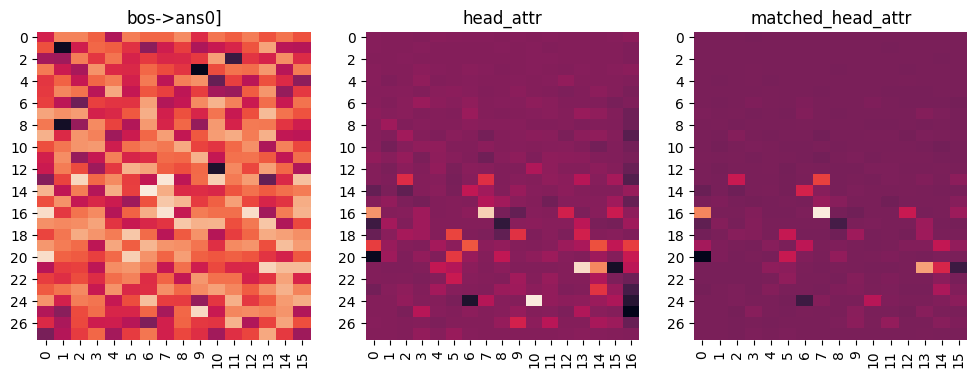

(array([14, 13, 16, 16, 20, 16, 25, 13, 21, 20]),
 array([ 6,  7,  7, 12,  0,  0,  9,  2, 13,  5]),
 array([-0.76847124, -0.91620743, -1.0253844 , -1.1890159 , -1.2004476 ,
       -1.2044504 , -1.3372848 , -1.4165361 , -1.4887413 , -1.6328306 ],
      dtype=float32))
(array([24, 21, 16, 16, 21, 19, 19, 18, 19, 19]),
 array([10, 13,  7,  0, 14,  6, 14,  5,  0, 16]),
 array([0.961745  , 0.89983845, 0.8550615 , 0.6408211 , 0.60438335,
       0.45135754, 0.433631  , 0.3990986 , 0.37840158, 0.37788907],
      dtype=float32))
(array([16, 21, 16, 13, 21, 14, 16, 13, 20, 18]),
 array([ 7, 13,  0,  7, 14,  6, 12,  2,  5,  5]),
 array([0.83389354, 0.604429  , 0.5320444 , 0.35702586, 0.27561784,
       0.26199418, 0.2219705 , 0.22174115, 0.22023506, 0.21290773],
      dtype=float32))
[0] top[0] 16-7 attn_labels


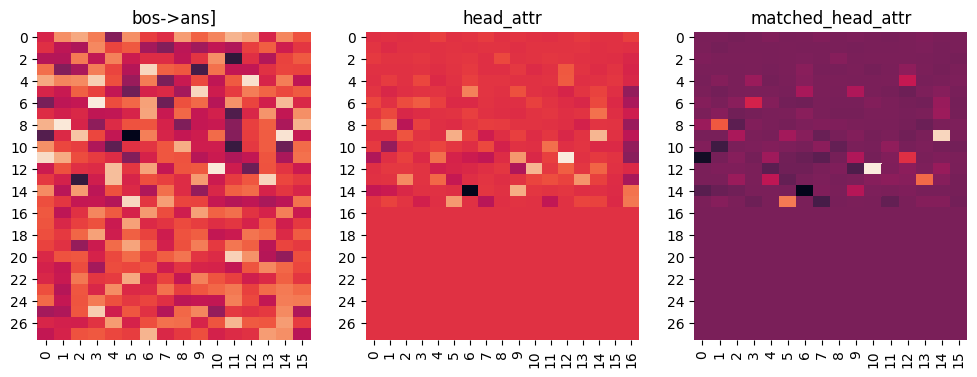

(array([ 6, 12,  8,  9,  4, 11, 15,  5,  3, 13]),
 array([ 3, 10,  1, 14, 12,  0,  5,  9,  6, 13]),
 array([-2.123184 , -2.2026026, -2.2260034, -2.3891857, -2.4952831,
       -2.658862 , -2.81563  , -2.8529582, -2.8708003, -2.9066348],
      dtype=float32))
(array([11, 12,  9,  9, 14, 15, 11, 13, 13,  5]),
 array([12, 10, 14,  5,  9,  5,  9, 13,  2,  6]),
 array([0.94266975, 0.6408508 , 0.6386491 , 0.59435934, 0.59105384,
       0.4876091 , 0.47970265, 0.4581871 , 0.40486157, 0.3693422 ],
      dtype=float32))
(array([12,  9, 15, 13,  8, 11,  6,  4, 13, 14]),
 array([10, 14,  5, 13,  1, 12,  3, 12,  4,  9]),
 array([0.2909516 , 0.26730826, 0.17317939, 0.1576349 , 0.14327697,
       0.10633796, 0.09084104, 0.07399539, 0.0668023 , 0.0574955 ],
      dtype=float32))
[1] top[0] 12-10


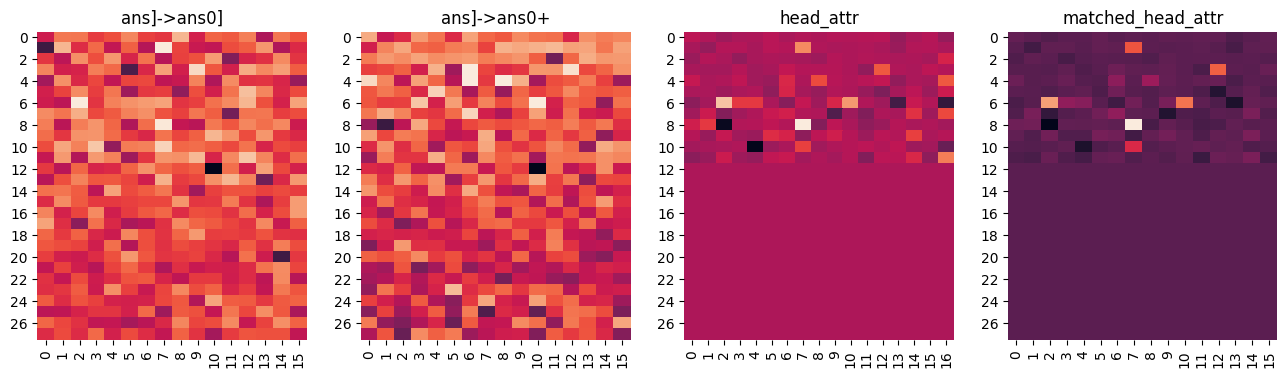

(array([ 1,  6,  8,  3, 10, 10, 11,  5, 11,  6]),
 array([ 7,  2,  7,  9,  7,  3, 12, 12,  9, 12]),
 array([-0.12368098, -0.13077638, -0.26115006, -0.78683645, -0.9868426 ,
       -1.4075432 , -1.4351188 , -1.6455195 , -1.8874338 , -1.9593313 ],
      dtype=float32))
(array([ 4,  6,  4,  3,  3,  4,  7,  5,  6, 23]),
 array([ 6, 10,  8,  6, 12,  0,  6,  4,  3,  5]),
 array([-0.31093156, -0.31979668, -0.3385723 , -0.34999603, -0.6376282 ,
       -0.84697556, -0.95705634, -1.0610068 , -1.3670614 , -1.6841705 ],
      dtype=float32))
(array([ 8,  6,  6,  1, 11,  4,  3,  4,  7, 10]),
 array([ 7,  2, 10,  7, 16, 16, 12,  8, 16,  7]),
 array([0.63601977, 0.5212428 , 0.40400568, 0.3651063 , 0.33129334,
       0.24795131, 0.24558514, 0.21417469, 0.21101579, 0.1912424 ],
      dtype=float32))
(array([ 8,  6,  6,  3,  1, 10,  4,  6,  7,  4]),
 array([ 7,  2, 10, 12,  7,  7,  8,  3,  6,  6]),
 array([0.29616523, 0.22044423, 0.18283053, 0.16659595, 0.15712117,
       0.11983133, 0.05907141, 0.04806

In [150]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [151]:
print(key); node = add_node_to_result(result, topi=[0, 1, 2, 3, 4])

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)
 [-1] root labels┐
                 └[0] top[0] 16-7 attn_labels┐
                                             └[1] top[0] 12-10┐
                                                              └*[2] top[0, 1, 2, 3, 4] 8-7,6-2,6-10,3-12,1-7...


In [177]:
def plot_attn_attrs(data_tuples, model, tokenizer, node, topi=[0]):
    for l, h in zip(*np.array(topk_md(get_matched_head_attr(node.data), 10)[:2])[:, topi]):
        print(l, h)
        for data_tuple in data_tuples:
            plot_attn_attr(data_tuple, model, tokenizer, node, l, h, k_shot=k_shot,
                attn_patterns=attn_patterns_by_step[node.data.step])

8 7
tensor([-3.7060, -2.2905, -2.1246, -2.4222])


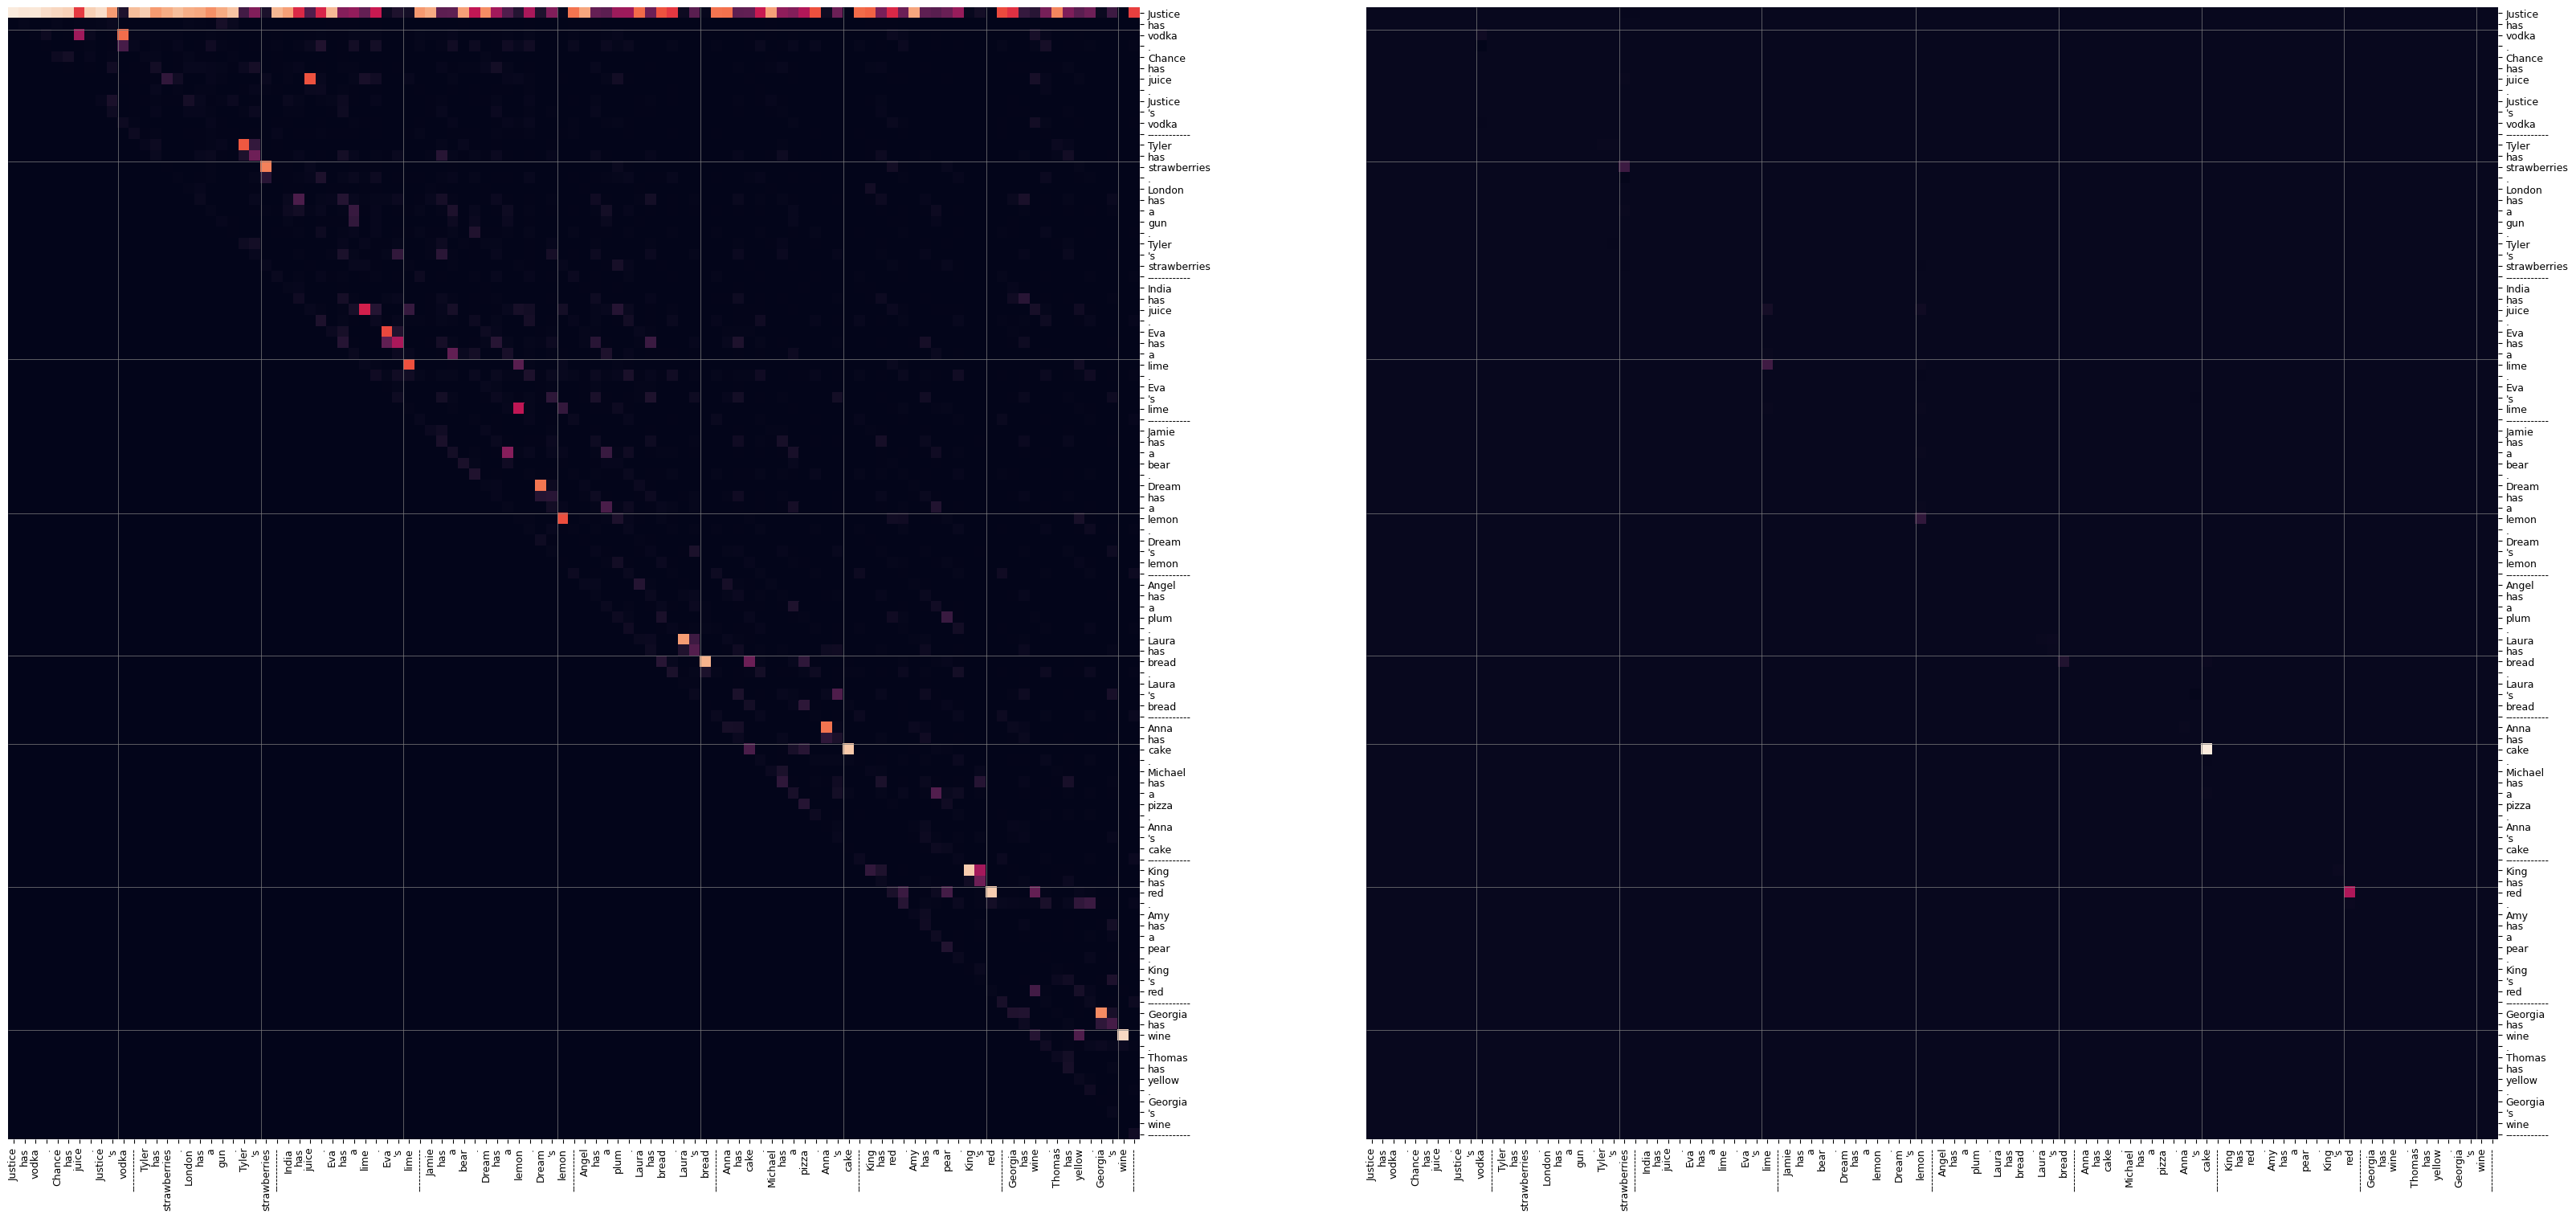

6 10
tensor([-3.7428, -2.2734, -1.7057, -1.7141])


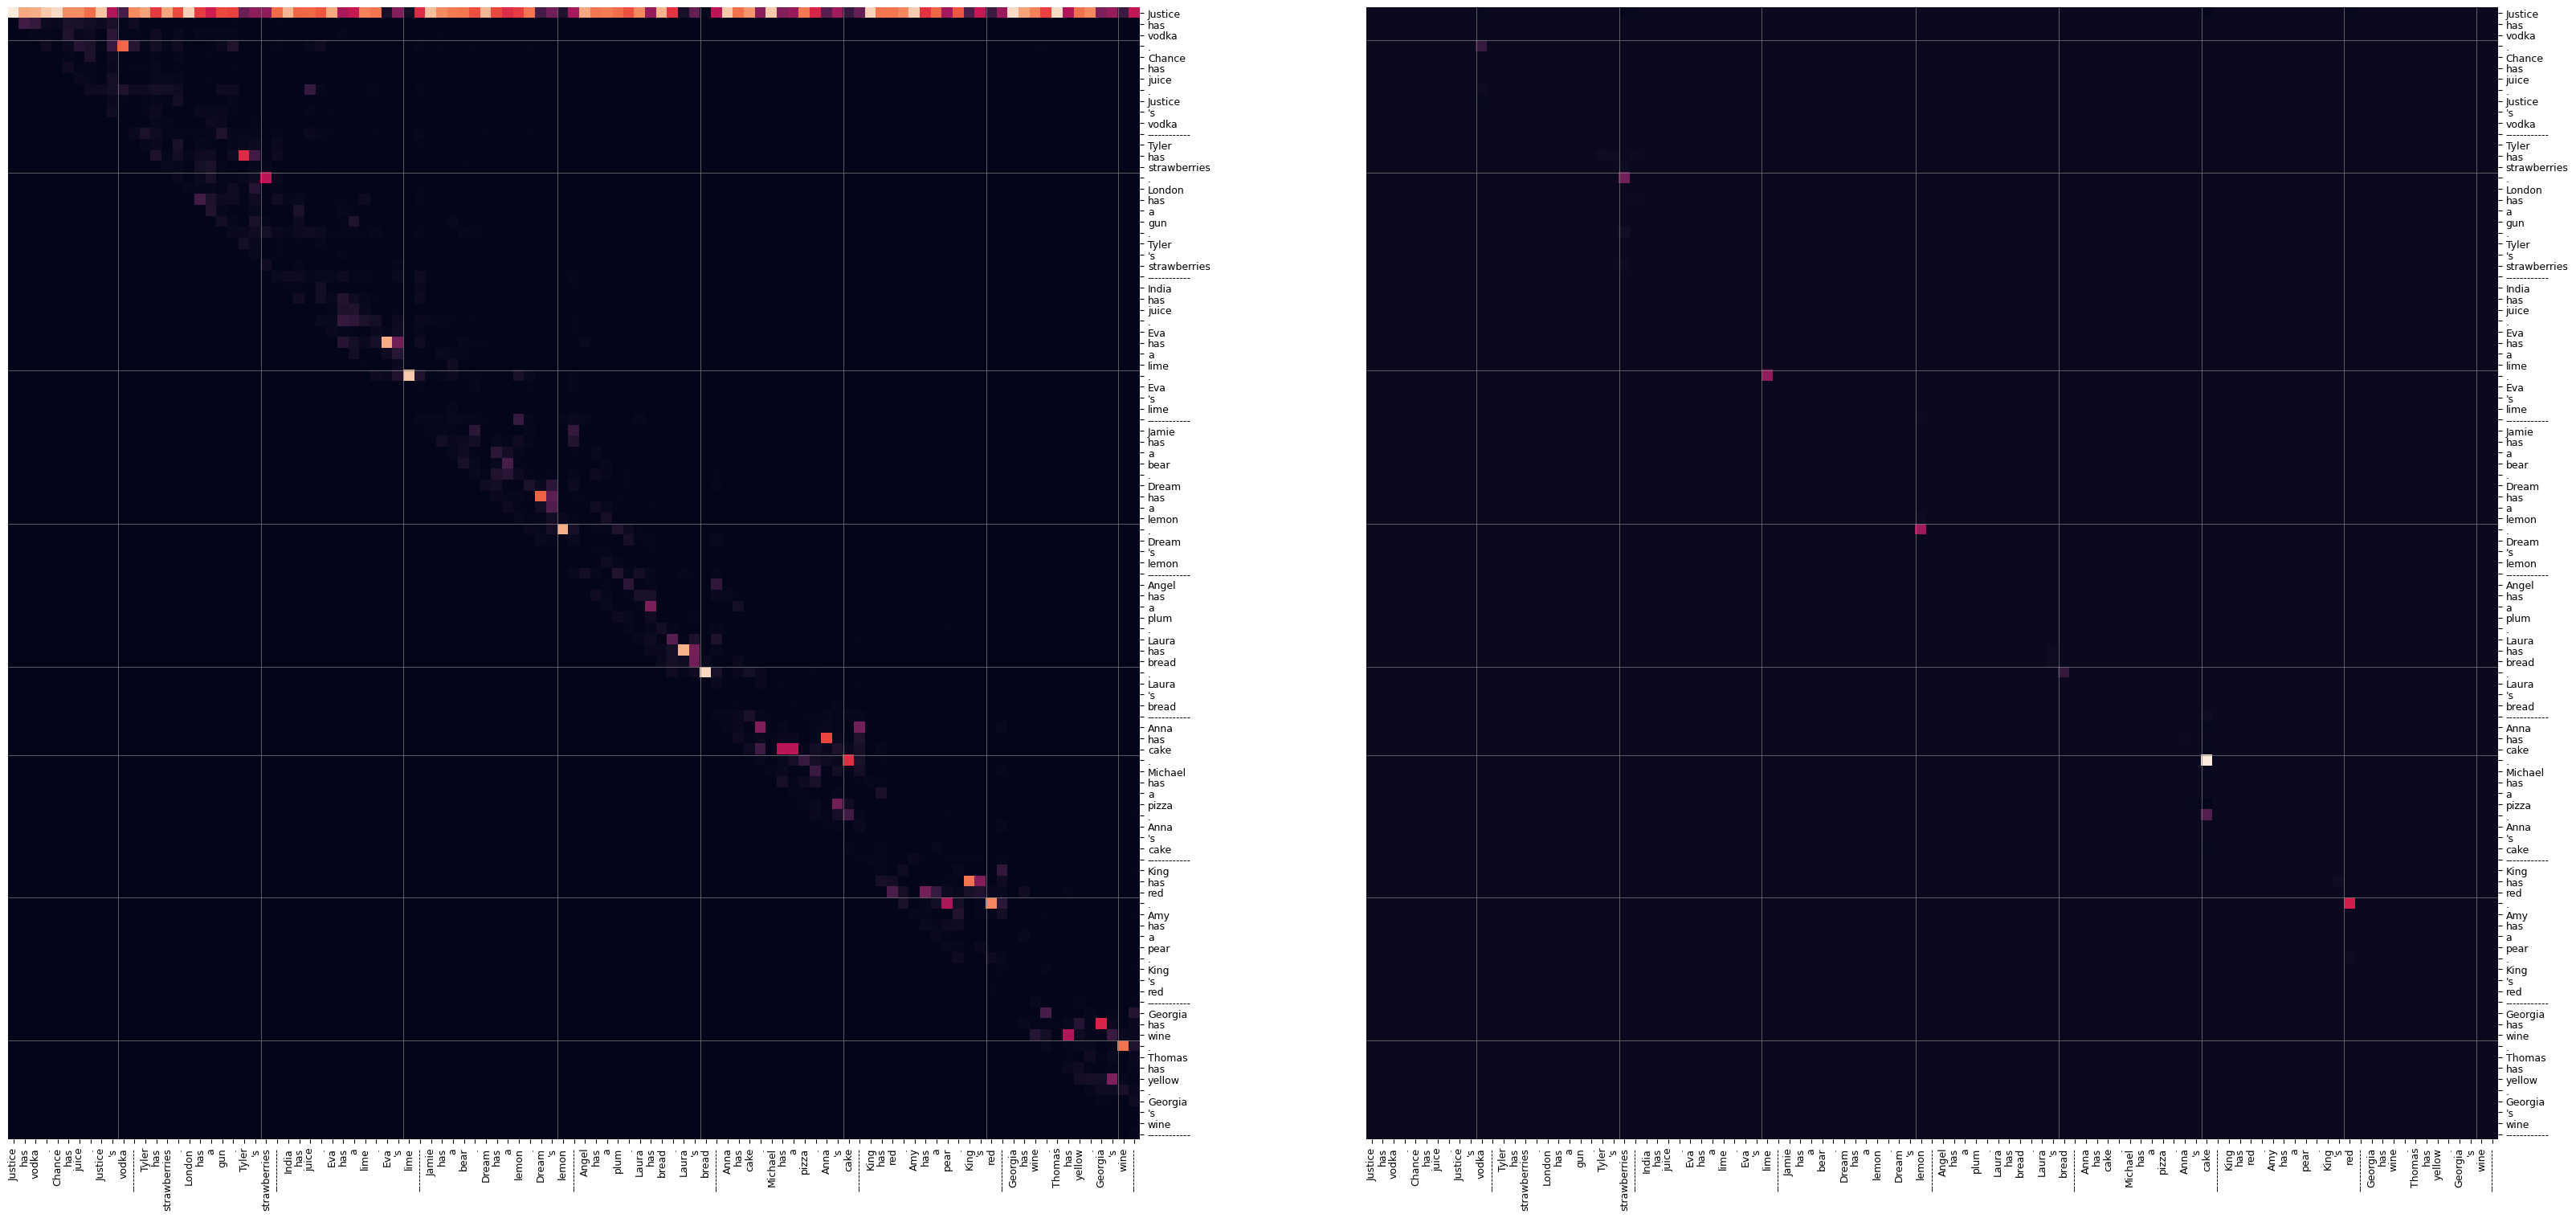

In [178]:
plot_attn_attrs(data_tuples[:1], model, tokenizer, node.parent, topi=[0, 2])  # step 2 relating heads 8-7, 6-10

12 10
tensor([-3.6134, -2.5552, -2.4820, -2.8550])


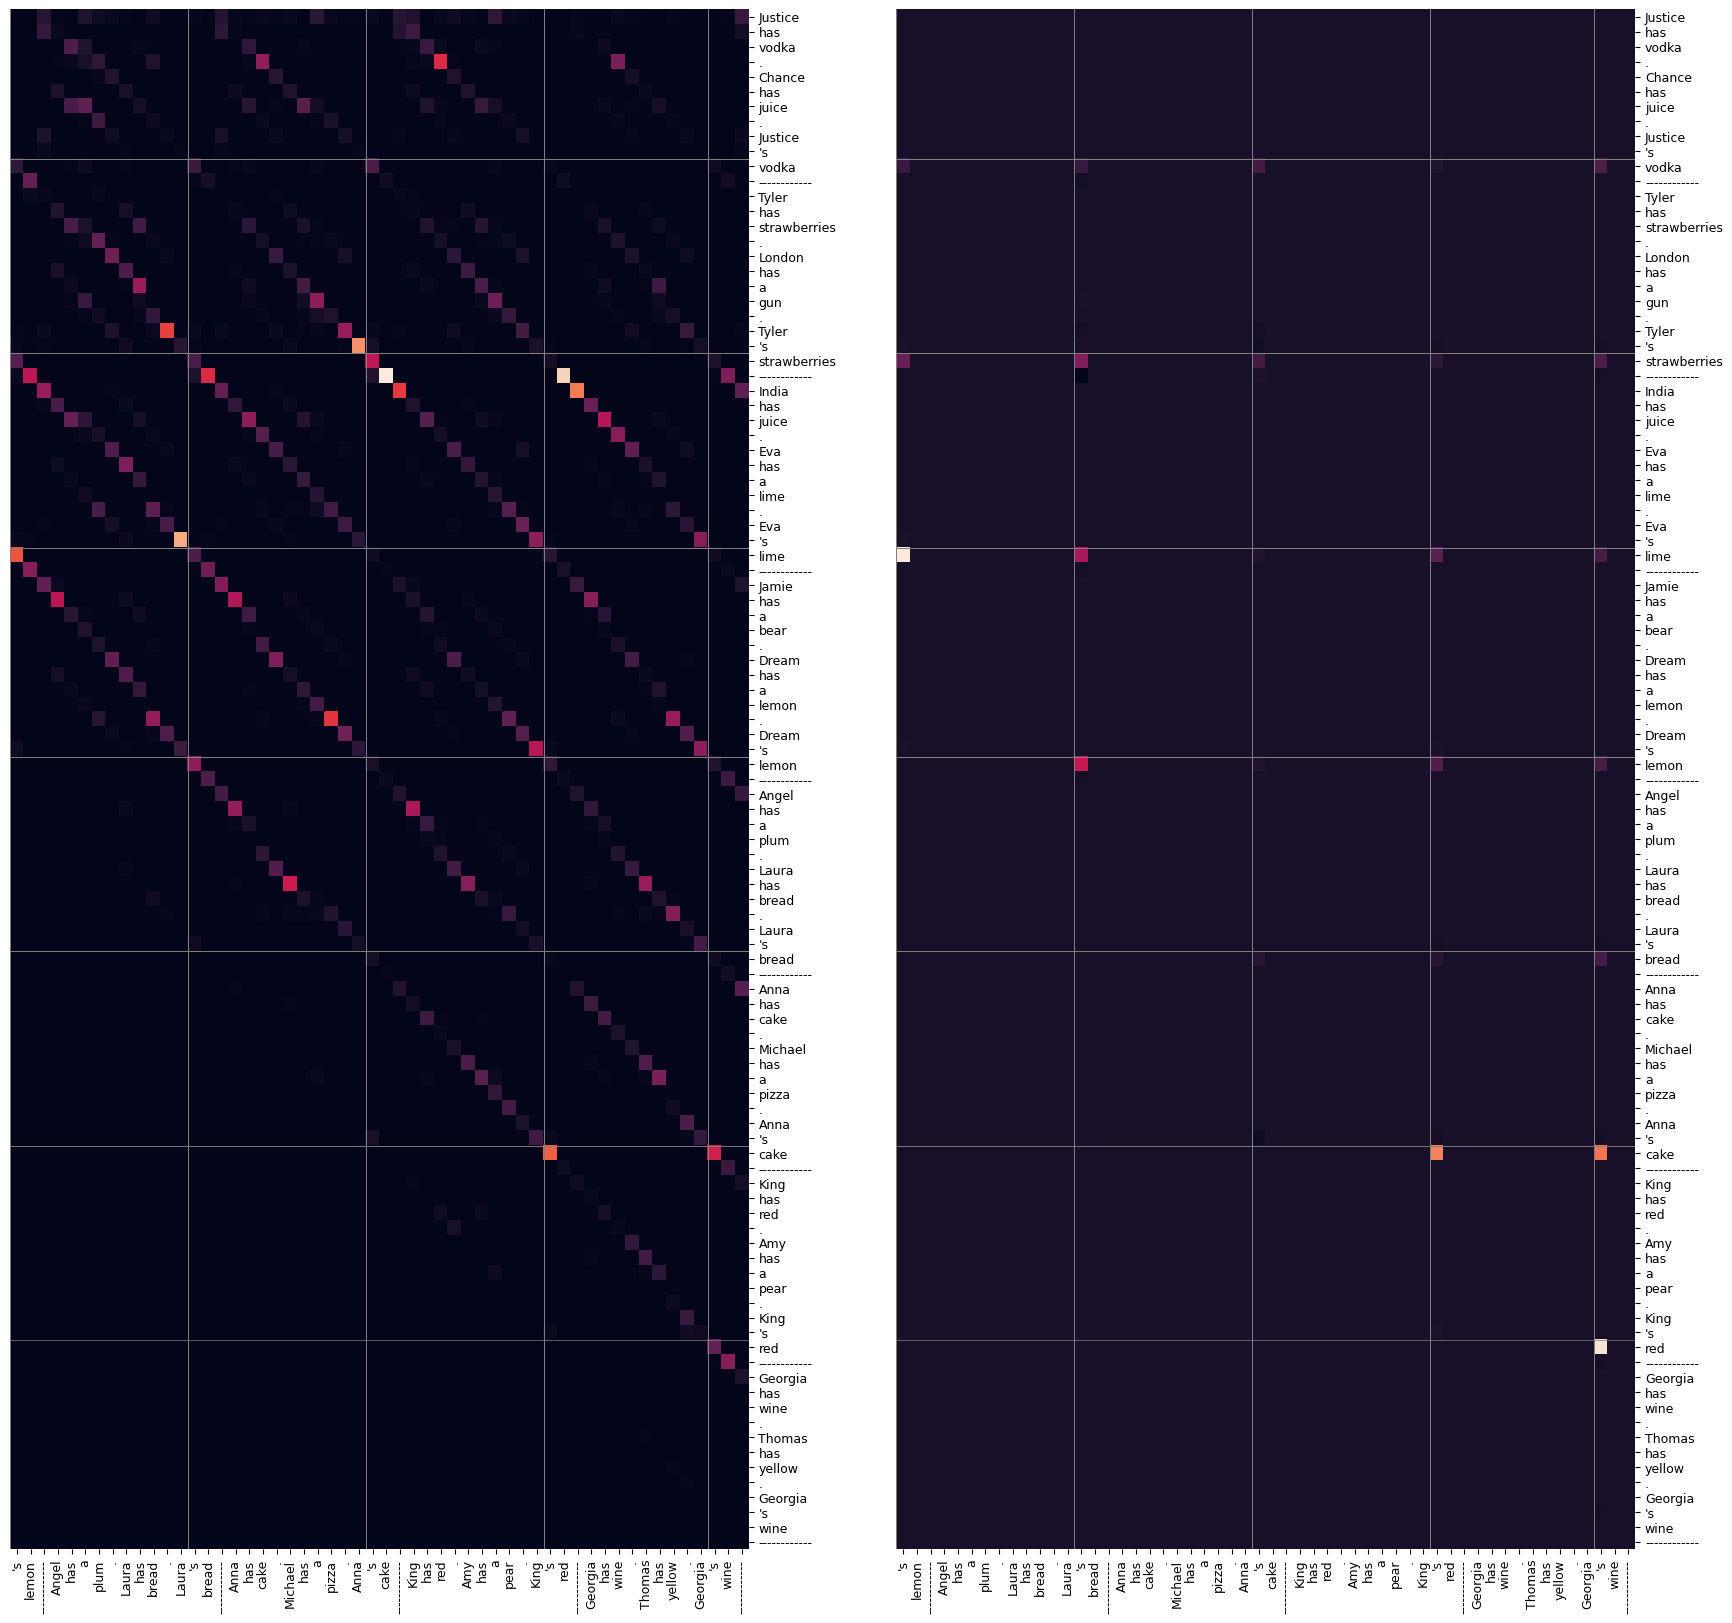

In [179]:
plot_attn_attrs(data_tuples[:1], model, tokenizer, node.parent.parent, topi=[0])  # step 1 intermediary head 12-10

16 7
tensor([-10.5445,  -2.6744,  -1.1017,  -1.0407])
 Ġvodka 0.222 {'ĠJuice': 0.294, 'Ġvodka': 0.222, 'Ġjuice': 0.137, 'j': 0.105} 	 Justice has vodka. Chance has juice. Justice's vodka
 Ġstrawberries 0.0 {'Ġvodka': 0.808, 'Ġjuice': 0.184, 'ĠJuice': 0.006, 'Ġjuices': 0.001} 	 Tyler has strawberries. London has a gun. Tyler's strawberries
 Ġlime 0.253 {'Ġa': 0.7, 'Ġlime': 0.253, 'ĠLime': 0.015, 'Ġgun': 0.012} 	 India has juice. Eva has a lime. Eva's lime
 Ġlemon 0.065 {'Ġlime': 0.9, 'Ġlemon': 0.065, 'ĠLime': 0.03, 'Ġcitrus': 0.002} 	 Jamie has a bear. Dream has a lemon. Dream's lemon
*Ġbread 0.717 {'Ġbread': 0.717, 'ĠBread': 0.28, 'bread': 0.003, 'Ġfood': 0.0} 	 Angel has a plum. Laura has bread. Laura's bread
*Ġcake 0.309 {'Ġcake': 0.309, 'cake': 0.246, 'ĠMichael': 0.179, 'Michael': 0.126} 	 Anna has cake. Michael has a pizza. Anna's cake
*Ġred 0.966 {'Ġred': 0.966, 'ĠRED': 0.019, 'Red': 0.005, 'ĠRed': 0.005} 	 King has red. Amy has a pear. King's red
 Ġwine 0.396 {'wine': 0.575, 'Ġwi

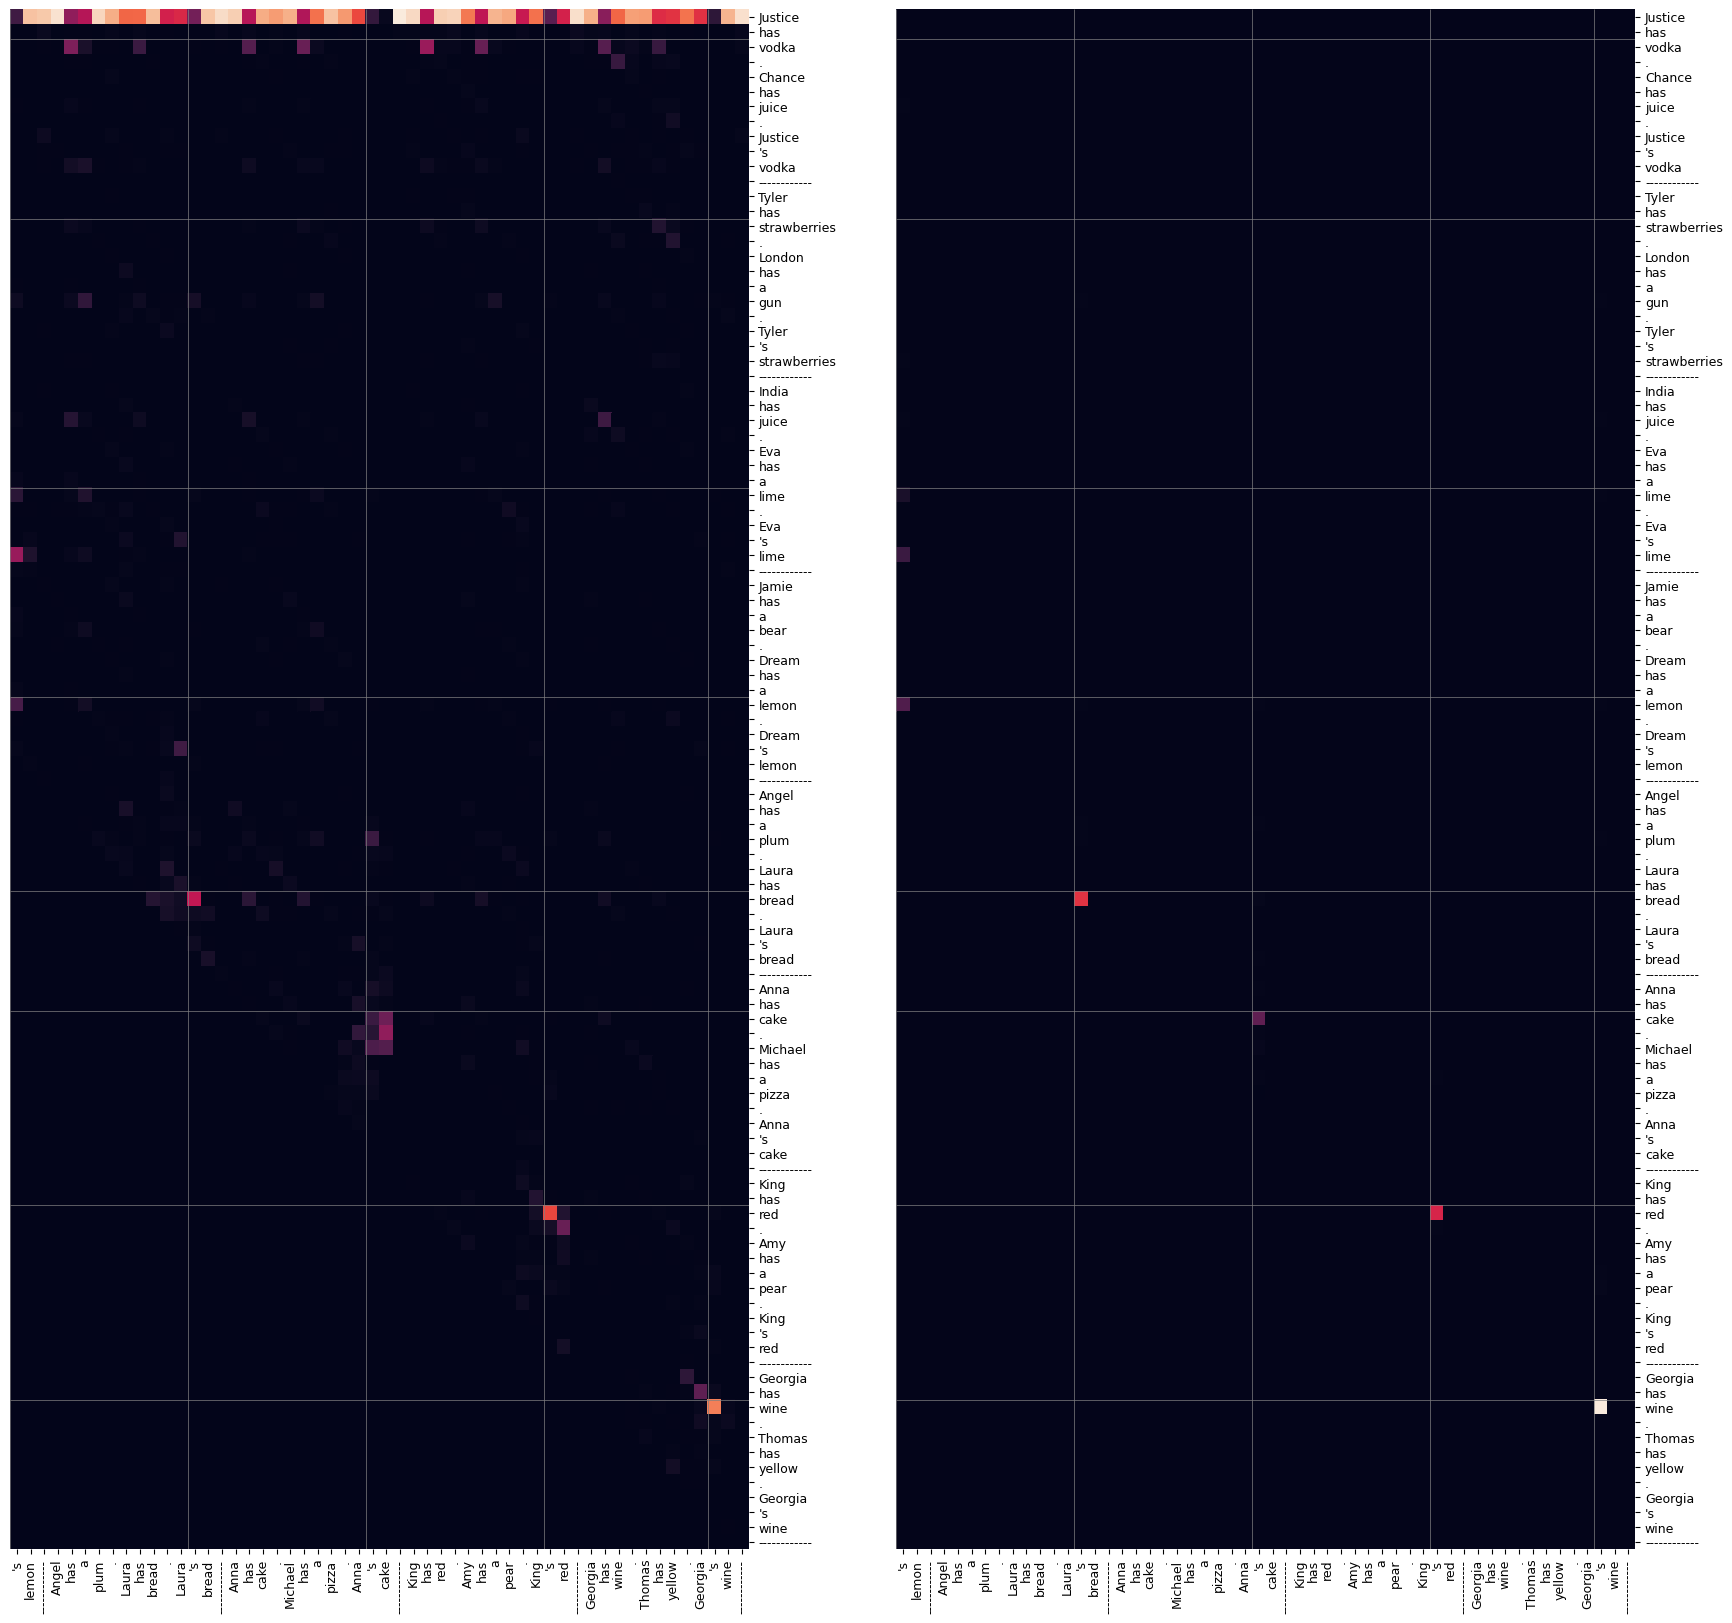

In [180]:
plot_attn_attrs(data_tuples[:1], model, tokenizer, node.parent.parent.parent, topi=[0])  # step 0 predicgting head 16-7

Alan has a blackberry. Jacob has an elephant. Alan's fruit
Morgan has a gun. Davis has a hamburger. Morgan's weapon
Austin has a deer. Thomas has meat. Thomas's food
                 ┌[0] top[0, 1, 3] 20-5,21-5,15-8 attn_labels┐
                 │                                           └*[1] top[0, 1] 8-1,12-10
 [-1] root labels┤
                 ├[0] 11-9 attn_labels┐
                 │                    └[1] top[0] 8-1┐
                 │                                   └[2] top[0, 1] 3-12,7-2
                 └[0] top[0, 1, 3] 20-5,21-5,15-8 argmax_attn_labels┐
                                                                    └[1] top[0, 1] 8-1,12-10┐
                                                                                            └[2] top[0, 1, 3] 5-12,3-12,7-2
[-1] root labels


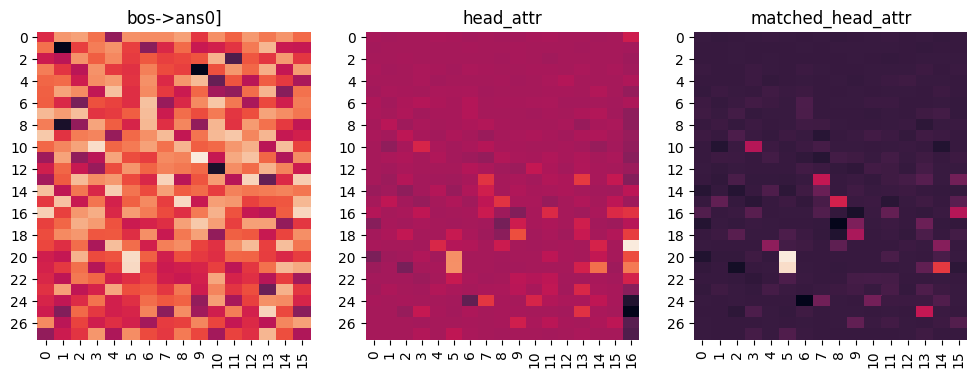

(array([11, 10, 20, 15, 21, 16, 13, 25, 13, 16]),
 array([ 9,  3,  5,  8,  5, 15, 12, 13,  7,  0]),
 array([-1.2674766, -1.6482041, -1.7172701, -1.7815722, -1.8076308,
       -1.8884598, -1.933879 , -1.9424105, -1.9547232, -2.0370746],
      dtype=float32))
(array([19, 21, 20, 21, 21, 18, 20, 18, 13, 24]),
 array([16,  5,  5, 16, 14,  9, 16, 16, 13,  7]),
 array([1.1065601 , 0.6738789 , 0.6702883 , 0.58036315, 0.5375647 ,
       0.41118476, 0.4067158 , 0.34230423, 0.32954222, 0.3187341 ],
      dtype=float32))
(array([20, 21, 21, 15, 13, 25, 10, 16, 18, 19]),
 array([ 5,  5, 14,  8,  7, 13,  3, 15,  9,  4]),
 array([0.390322  , 0.37279677, 0.20106155, 0.17056097, 0.1526186 ,
       0.15236934, 0.13750218, 0.13642497, 0.12428343, 0.09571555],
      dtype=float32))
[0] top[0, 1, 3] 20-5,21-5,15-8 attn_labels


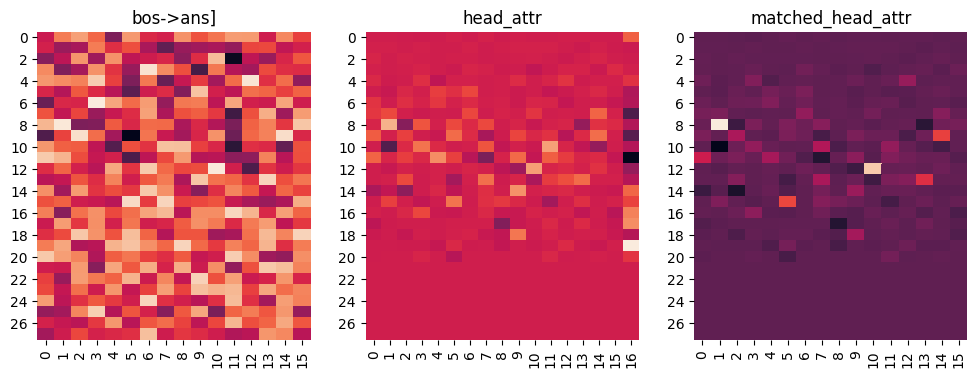

(array([ 6, 12,  8,  4,  3,  9,  9, 15, 16, 24]),
 array([ 3, 10,  1, 12,  6,  2, 14,  5, 11,  6]),
 array([-2.1202505, -2.1813905, -2.2281203, -2.3211892, -2.4319775,
       -2.5134633, -2.528109 , -2.6391044, -2.7577412, -2.7972775],
      dtype=float32))
(array([19,  8, 10, 12, 14, 17, 11, 16, 18, 15]),
 array([16,  1, 11, 10,  9, 16,  4, 16,  9,  5]),
 array([0.6698531 , 0.45983768, 0.40328616, 0.39848846, 0.35765412,
       0.3453579 , 0.34316713, 0.30421916, 0.27467614, 0.26424968],
      dtype=float32))
(array([ 8, 12, 15,  9, 13, 11, 10,  9, 13, 11]),
 array([ 1, 10,  5, 14, 13,  0,  7,  2,  7,  4]),
 array([0.20637919, 0.18267635, 0.10012855, 0.09701532, 0.08507187,
       0.07069803, 0.05257459, 0.04743757, 0.04717468, 0.04504041],
      dtype=float32))
[1] top[0, 1] 8-1,12-10


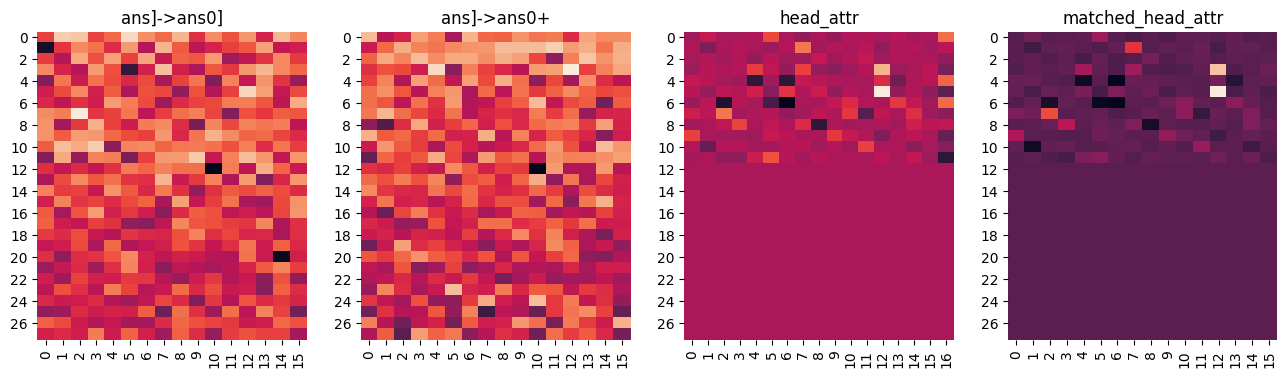

(array([ 7,  0,  5,  0, 10, 11,  0,  3, 10, 11]),
 array([ 2,  5, 12,  1,  3,  9,  2,  7,  1, 12]),
 array([-0.8029821, -1.3519015, -1.4143901, -1.6527418, -1.654027 ,
       -1.7690463, -1.8784103, -2.040913 , -2.0806189, -2.134634 ],
      dtype=float32))
(array([ 3,  3,  1,  2, 24, 23,  1,  2, 10,  1]),
 array([12,  4, 11, 13, 10,  5,  8,  3, 14,  9]),
 array([-0.7665804, -1.2390473, -1.479734 , -1.749217 , -1.8781241,
       -1.8878758, -1.9278226, -1.9299415, -1.9315186, -1.9402082],
      dtype=float32))
(array([ 5,  3,  7,  1,  0,  6,  4, 11,  0,  8]),
 array([12, 12,  2,  7, 16, 16, 16,  5,  5,  3]),
 array([0.86935115, 0.65089214, 0.43882847, 0.4347899 , 0.40814888,
       0.39541632, 0.37949353, 0.32751548, 0.29330683, 0.28055373],
      dtype=float32))
(array([ 5,  3,  7,  1,  8,  9,  3,  3,  0, 10]),
 array([12, 12,  2,  7,  3,  0,  4,  7,  5, 11]),
 array([0.38553452, 0.33191723, 0.19622234, 0.1699038 , 0.11536194,
       0.09843516, 0.08393712, 0.08256423, 0.07644407, 0.0

In [205]:
key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)'; result = results[key]
node, data_tuples = show_result(result)

In [199]:
result.node = result.node.parent.parent.parent

In [206]:
print(key); node = add_node_to_result(result, topi=[0,1,2])#, label_type='attn_labels')

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)
                 ┌[0] top[0, 1, 3] 20-5,21-5,15-8 argmax_attn_labels┐
                 │                                                  └[1] top[0, 1] 8-1,12-10┐
                 │                                                                          └[2] top[0, 1, 3] 5-12,3-12,7-2
 [-1] root labels┤
                 ├[0] top[0, 1, 3] 20-5,21-5,15-8 attn_labels┐
                 │                                           └[1] top[0, 1] 8-1,12-10┐
                 │                                                                   └*[2] top[0, 1, 2] 5-12,3-12,7-2...
                 └[0] 11-9 attn_labels┐
                                      └[1] top[0] 8-1┐
                                                     └[2] top[0, 1] 3-12,7-2


pmapped batch_predict ... done 0:00:00.000024
 Ġjacket 0.002 {'ĠJonathan': 0.043, 'ĠRaven': 0.036, 'Ċ': 0.014} 	 Kate beetle, Raven microwave, Jonathan jacket. Jonathan -> jacket
*Ġcherry 0.498 {'Ġcherry': 0.498, 'Ġbomb': 0.217, 'Ġspan': 0.125} 	 Walker cherry, Anne bomb, Eric spanner. Walker -> cherry
*Ġtaxi 0.701 {'Ġtaxi': 0.701, 'Ġtiger': 0.05, 'Ġjacket': 0.038} 	 Max taxi, Justice tiger, London jacket. Max -> taxi
 Ġcat 0.081 {'Ġant': 0.807, 'Ġcat': 0.081, 'ĠDream': 0.038} 	 Dream ant, John cat, James train. John -> cat
*Ġpap 0.988 {'Ġpap': 0.988, 'Ċ': 0.002, 'Ġcherry': 0.001} 	 Danny papaya, Paris helicopter, India cherry. Danny -> papaya
*Ġelephant 0.831 {'Ġelephant': 0.831, 'Ġsaw': 0.093, 'Ċ': 0.007} 	 Danny saw, Rose elephant, Matthew goose. Rose -> elephant
 Ġcat 0.038 {'Ġwater': 0.556, 'Ġgoose': 0.358, 'Ġcat': 0.038} 	 Virginia watermelon, Brian goose, Jennifer cat. Jennifer -> cat
*Ġlime 0.994 {'Ġlime': 0.994, 'ĠLime': 0.001, 'Ġlemon': 0.001} 	 Ocean lime, Robin sunflower, J

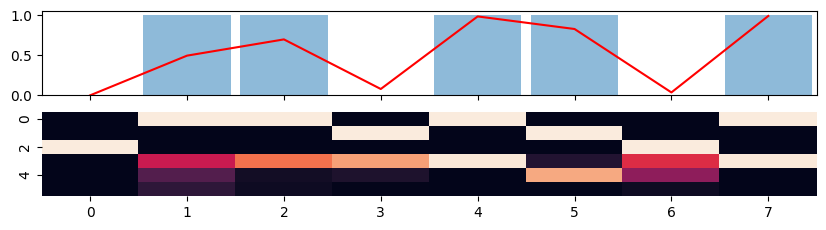

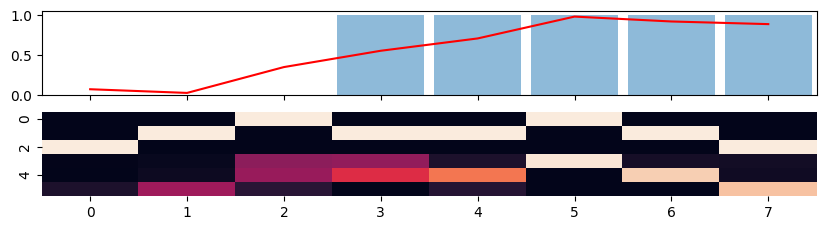

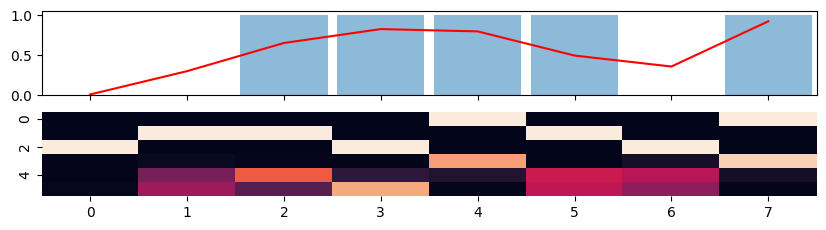

In [334]:
# seed(1234); torch.cuda.empty_cache()
model_names = ['EleutherAI/gpt-j-6B/cpu', 'EleutherAI/gpt-neox-20b', #'EleutherAI/gpt-neox-20b/cpu', 
               'text-curie-001', 'text-davinci-001', 'text-davinci-002'][:1]
metrics = dict(losses=defaultdict(list), accuracies=defaultdict(list))

def batch_predict(model, tokenizer):
    return [predict(model, tokenizer, text, examples, k_shot=k_shot, custom_forward=False, # avoid computing head_inputs
                    bos_token=bos_token, eos_token=eos_token, verbose=len(model_names) == 1)[1]
            for text, examples in zip(texts, all_examples)]
    
with Timer('pmapped batch_predict'):
    parallel = len(model_names) > 1
    pool = Pool(len(model_names)) if parallel else itertools  # with Pool(len(model_names)) as pool:
    results = pool.starmap(batch_predict, [models[model_name] for model_name in model_names])
    if parallel: pool.close(); pool.join()
            
# query2acc, query2loss = defaultdict(list), defaultdict(list)
for model_name, r in zip(model_names, results):
    _, tokenizer = models[model_name]
    for i, (loss, top1_corrects, answer_indices, answer_probs, candidate_probs) in enumerate(r):#.get()
        acc = top1_corrects[k_shot:] # np.array(top1_corrects[k_shot:]).mean()
        metrics['losses'][model_name].append(loss); metrics['accuracies'][model_name].append(acc)
        if batch_size == 1: print(model_name, loss, acc)
#         queries = [e[1] for e in _examples_list[i]][k_shot:]
#         for q, a, l in zip(queries, acc, loss): query2acc[q].append(float(a)); query2loss[q].append(l)
# print(sorted([(q, np.array(v).mean()) for q, v in query2acc.items()], key=lambda x: x[1]))

In [156]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name]).mean())

accuracies EleutherAI/gpt-j-6B/cpu 0.4444444444444444
accuracies EleutherAI/gpt-neox-20b 0.5555555555555556
accuracies text-curie-001 0.3333333333333333
losses EleutherAI/gpt-j-6B/cpu 3.0475401878356934
losses EleutherAI/gpt-neox-20b 2.3752387364705405
losses text-curie-001 5.4890399882962955


In [129]:
def cmp(a, b):
    print(a.dtype, a.size(), b.dtype, b.size())
    print('allclose:', torch.allclose(a, b), 'equal:', torch.equal(a, b))
    print((a == b).float().mean())
    print((a - b).float().abs().mean(), a.float().abs().mean(), b.float().abs().mean())
#     print((a - b).max(), (a - b).min())
#     print(a[a - b == (a - b).max()])
#     print(a[a - b == (a - b).min()])

In [47]:
# text, _examples = texts[0], _examples_list[0]
torch.cuda.empty_cache()
if True: #def predict2(model, tokenizer, text, _examples):
    examples, input_ids, tokens, bos_indices, eos_indices, answers, labels = make_data_tuple(
        text, tokenizer, k_shot=k_shot, bos_token=bos_token, eos_token=eos_token)
    candidates = [[tokenizer.encode(' ' + token)[0] for token in cands[0]] for _, _, cands, _ in _examples]
    with torch.no_grad():
        with Timer(): o0 = model(input_ids.to(model.device), output_attentions=True, output_hidden_states=True)
        with Timer(): o1 = forward0(model, input_ids.to(model.device), labels=labels.to(model.device),
                by_head=['head_input0', 'head_output0'], attn_weights=None, output_hidden_states=True)
        for o in [o0, o1]:
            logits = o.logits
            if isinstance(logits, torch.Tensor): logits = logits.to('cpu').float()# softmax on cpu needs float32
            loss, top1_corrects, answer_probs, candidate_probs = show_predictions(
                examples, tokenizer, logits, bos_indices, eos_indices, answers, labels, loss_reduction='none',
                candidates=candidates, k_shot=k_shot, topk=3, verbose=True)
            print('\n')
#     return loss, top1_corrects, answer_probs, candidate_probs

 ... done 0:00:02.348918
 ... done 0:00:01.659792
 ĠJ 0.032 {'Ċ': 0.074, 'ĠS': 0.038, 'Ġ': 0.036} 	 S J Y -> J
*ĠN 0.429 {'ĠN': 0.429, 'ĠR': 0.223, 'ĠA': 0.074} 	 A N R -> N
 ĠC 0.247 {'ĠV': 0.649, 'ĠC': 0.247, 'ĠB': 0.018} 	 B C V -> C
*ĠT 0.443 {'ĠT': 0.443, 'ĠK': 0.393, 'ĠS': 0.085} 	 S T K -> T
*ĠR 0.839 {'ĠR': 0.839, 'ĠT': 0.099, 'ĠA': 0.021} 	 A R T -> R
*ĠH 0.562 {'ĠH': 0.562, 'ĠQ': 0.278, 'ĠE': 0.112} 	 E H Q -> H
*ĠO 0.792 {'ĠO': 0.792, 'ĠF': 0.161, 'ĠN': 0.013} 	 N O F -> O
*ĠA 0.626 {'ĠA': 0.626, 'ĠI': 0.225, 'ĠY': 0.11} 	 Y A I -> A


 ĠJ 0.032 {'Ċ': 0.074, 'ĠS': 0.038, 'Ġ': 0.036} 	 S J Y -> J
*ĠN 0.429 {'ĠN': 0.429, 'ĠR': 0.223, 'ĠA': 0.074} 	 A N R -> N
 ĠC 0.247 {'ĠV': 0.649, 'ĠC': 0.247, 'ĠB': 0.018} 	 B C V -> C
*ĠT 0.443 {'ĠT': 0.443, 'ĠK': 0.393, 'ĠS': 0.085} 	 S T K -> T
*ĠR 0.839 {'ĠR': 0.839, 'ĠT': 0.099, 'ĠA': 0.021} 	 A R T -> R
*ĠH 0.562 {'ĠH': 0.562, 'ĠQ': 0.278, 'ĠE': 0.112} 	 E H Q -> H
*ĠO 0.792 {'ĠO': 0.792, 'ĠF': 0.161, 'ĠN': 0.013} 	 N O F -> O
*ĠA 0.62

In [176]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name]).mean())

accuracies EleutherAI/gpt-j-6B 0.4976851851851852
accuracies EleutherAI/gpt-neox-20b 0.5023148148148148
accuracies text-davinci-001 0.48148148148148145
accuracies text-davinci-002 0.9675925925925926
losses EleutherAI/gpt-j-6B 1.3536101162543572
losses EleutherAI/gpt-neox-20b 1.1634638377252957
losses text-davinci-001 1.687816629922939
losses text-davinci-002 0.1085046497381794


In [136]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name])[:,:27].mean())

accuracies EleutherAI/gpt-j-6B 0.6203703703703703
accuracies EleutherAI/gpt-neox-20b 0.7083333333333334
accuracies text-curie-001 0.5879629629629629
losses EleutherAI/gpt-j-6B 1.5619440356433054
losses EleutherAI/gpt-neox-20b 1.0779137232247094
losses text-curie-001 3.1073556870623844


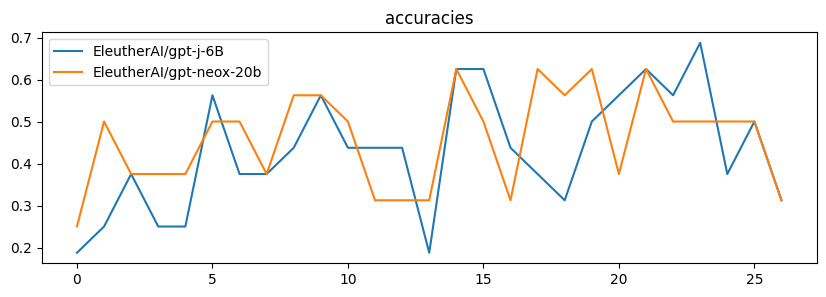

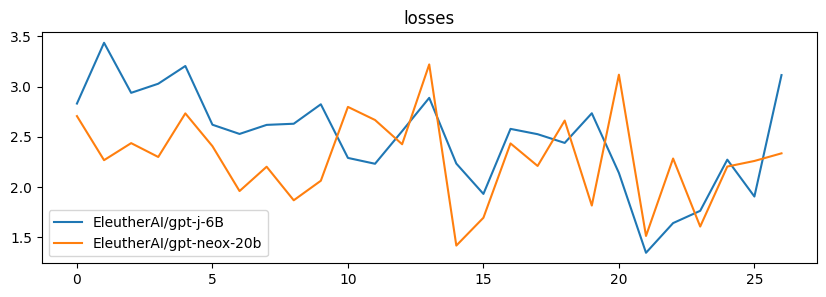

In [191]:
for metric in ['accuracies', 'losses']:
    _ = plt.figure(figsize=(10, 3));
    for model_name in model_names[:2]:
        plt.plot(np.array(metrics[metric][model_name])[:].mean(0), label=f'{model_name}');
    _ = plt.legend();  _ = plt.title(metric); _ = plt.show();

In [11]:
time2prep = {tuple(clock_of_day): 'at', tuple(days_of_week): 'on', tuple(months): 'in'}
def lookup_item2str(item, vocab=None):
    if vocab[0] in [clock_of_day, days_of_week, months]:
        prep = time2prep[tuple(vocab[0])]
        return f'{item[1]} came {prep} {item[0]}'
    elif vocab[0] == digits:
        return f'{item[1]} is {item[0]}'
def lookup_query2str(query, vocab=None, rel_name=None):
    if vocab[0] in [clock_of_day, days_of_week, months]:
        prep = time2prep[tuple(vocab[0])]
        prep = {'prev': 'just before', 'next': 'just after', 'same': prep}[rel_name]
        return f'Who came {prep} {query}?'
    elif vocab[0] == digits:
        prep = {'prev': 'a year younger than', 'next': 'a year younger than', 'same': ''}[rel_name]
        return f'Who is {prep} {query}'

In [81]:
text = '''Aaren is a boy. Harlow is a girl.
Harlow called Aaren.
Harlow: "Are you a girl?"
Aaren: "'''
model_name = 'EleutherAI/gpt-j-6B'
model, tokenizer = models[model_name]
input_ids = tokenizer.encode(text, return_tensors='pt')
logits = model(input_ids.to(getattr(model, 'device', 'cpu'))).logits

In [80]:
show_topk(*logits[0][-1].softmax(-1).topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

{'Yes': 0.35, 'No': 0.226, 'Yeah': 0.078, 'I': 0.078, 'Y': 0.021}

In [75]:
get_prob_dist(logits.top_logprobs[-1], 5)

{'No': 0.824, 'Yes': 0.115, 'I': 0.04, 'What': 0.006, ' No': 0.003}

In [155]:
text = 'The capital of Canada is'
input_ids = tokenizer(text, return_tensors='pt').input_ids
list(zip(tokenizer.convert_ids_to_tokens(input_ids[0]), input_ids[0].numpy()))
outputs = model.generate(input_ids, max_length=10)
tokenizer.decode(outputs[0], skip_special_tokens=True)

[('▁The', 37),
 ('▁capital', 1784),
 ('▁of', 13),
 ('▁Canada', 1894),
 ('▁is', 19),
 ('</s>', 1)]

'Ottawa. It is the largest city in Canada'

In [478]:
# nrows = 5; k_shot = nrows // 2 + 1
# for pairs in [drop_first_and_last, ]:
nrows = 6;  k_shot = 3
for pairs in reversible_transformations + irreversible_transformations:
    seps = [' -> ', '->'] if random.random() < 0.5 else ['->', ' -> ']
    # seps = [' -> ', ' -> ']
    samples = ['\n' + '\n'.join(a + seps[0] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[0])[0])))
    samples = ['\n' + '\n'.join(b + seps[1] + a for a, b in sample(pairs, nrows)) + '\n' if pairs in reversible_transformations else 
                '\n' + '\n'.join(a + seps[1] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[1])[0])))

In [ ]:
# # sys.path.insert(0, '/nas/xd/projects/ec')
# from child_utils import loadPBETasks, retrieveJSONTasks
# challenge, challengeCheating = loadPBETasks('/nas/xd/projects/ec/PBE_Strings_Track')
# challenge2, challengeCheating2 = loadPBETasks('/nas/xd/projects/ec/data/sygus')
# tasks = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks.json")
# tasks2 = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks2.json")

In [ ]:
from lxy_utils import get_examples_behind, get_examples_before, get_examples_query_before, \
    get_examples_query_behid, get_examples_query_repeat

In [ ]:
reversible_transformations = [list(digit2cardinal.items()), noun2adj, lxy, verb_form, country2capital, en2fr, antonyms]
irreversible_transformations = [capabilities]

In [197]:
losses = []
for model_name, (model, tokenizer) in models.items():
    if any(model_name.startswith(s) for s in ['gpt2-', 'KoboldAI/fairseq-dense', 'text-davinci-001', ]): continue
    if not model_name == 'EleutherAI/gpt-j-6B': continue
    if not isinstance(model, types.FunctionType): _ = model.eval()
    with Timer(model_name): outputs = model(**inputs)
    options_ids_list = [[tokenizer.encode(' ' + option)[0] for option in options] for cxt, query, options, ans in _examples]
    mask_logits_fn = partial(mask_logits, indices=bos_indices, kept_ids=options_ids_list)
    loss, all_top1_correct = show_predictions(text, examples, tokenizer, outputs.logits, bos_indices, eos_indices, answers, labels,
                    mask_logits_fn=None, topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t')
    print(loss, all_top1_correct, '\n')
    losses.append(loss.item() if hasattr(loss, 'item') else loss)
    if model_name == 'EleutherAI/gpt-j-6B': break
print(sum(losses) / len(losses))

EleutherAI/gpt-j-6B ... done 0:00:01
* C 0.842 {' C': 0.842, ' A': 0.041, ' B': 0.04} 	 D -> C
* Thursday 0.778 {' Thursday': 0.778, ' Wednesday': 0.064, ' Friday': 0.063} 	 Friday -> Thursday
* a 0.742 {' a': 0.742, ' c': 0.051, ' A': 0.036} 	 b -> a
* four 0.472 {' four': 0.472, ' three': 0.246, ' one': 0.105} 	 five -> four
tensor(0.3677, grad_fn=<NllLossBackward>) True 

0.3677041530609131


In [24]:
relational_functions = [prev(), next()]
rel_fns = [prevs, nexts]

**TODO: read children books for more posets**  
**TODO: Prompt gpt3 to elicit the posets it knows**  
$x \to f(x)$ where $f \in \{\text{prev/next in posets of numbers/letters/months/days, antonym, hypernym, hyponym, ...}\}$  
$x \to f^2(x)$  
one poset or mixed posets  
$x, f(x).~y \to Ff^{[-1]}(y)$ one poset or mixed posets  
$x, f^k(x).~y \to Ff^{[-1]}(y)~/Ff^{[-]k}(y)$  
$x, f(f(x))~/f(f(x)), x \to f(x)$ in between, the simplest form of sequence completion  
$x, f(x) \to Gf$ where $Gf \in \{<, >\}$  
$x, f(x); y, g(y) \to Ff \stackrel{?}{=} g^{[-1]}$ where $\text{output} \in \{\text{True}, \text{False}\}$  
sort

There is a *natural* monotone map/functor $F$ between posets/sets $A$ and $B$.  Compose the computation (set operations, sorting etc.) between $A$ and $B$ with $F$ to make harder tasks.  
$P(A) ,P(B) \to F(P(A)) \setminus ~/ \cap ~/ \triangle P(B)$. Harder form of set difference/intersection.  
$P(A) \to F(\text{sorted}(P(A)))$. Harder form of sorting.


In [385]:
n_total, n_valid = 192, 64
n_train = n_total - n_valid

input_strs = [make_input_str(tasks[4], nrows=4, ncols=5) for __ in range(n_total)]
for s in sample(input_strs, 3): print(s)

Instruction: replace with the other. For example:
G H G G G -> H G H H H
I I I I M -> M M M M I
A A F A A -> F F A F F
9 9 9 I I -> I I I 9 9

Instruction: replace with the other. For example:
V Q Q V V -> Q V V Q Q
G L L G L -> L G G L G
G 2 2 2 G -> 2 G G G 2
I I Z Z Z -> Z Z I I I

Instruction: replace with the other. For example:
R H H H R -> H R R R H
B 9 9 B B -> 9 B B 9 9
D 2 2 2 D -> 2 D D D 2
A A A A W -> W W W W A



In [368]:
sum(s.count('Yes') for s in input_strs)

370

In [322]:
train_dataset = CHILDDataset(input_strs[:-n_valid], tokenizer)
eval_dataset = CHILDDataset(input_strs[-n_valid:], tokenizer)

In [121]:
if n_total == 1:
    inputs = tokenizer.encode_plus(text, return_tensors='pt')
    inputs = prepare_inputs(inputs, model.device)
    outputs = model(**inputs, output_attentions=False)

    # assert inputs.input_ids.size(0) == 1
    input_ids = inputs.input_ids
    logits = outputs.logits

    bsz = input_ids.size(0); assert bsz == 1
    labels = torch.ones_like(input_ids) * (-100)
    for bi in range(bsz):
        bos_indices = (input_ids[bi] == bos_id).nonzero().squeeze(1)
        eos_indices = (input_ids[bi] == eos_id).nonzero()[-nrows:].squeeze(1)
        for i, (example, bos_i, eos_i) in enumerate(zip(examples, bos_indices.tolist(), eos_indices.tolist())):
            print(' ' + make_example_str(example))
            ans_ids = input_ids[bi, bos_i + 1: eos_i]
            if i >= 2: labels[bi, bos_i: eos_i - 1] = ans_ids
            ans_prob_dist = logits[bi, bos_i: eos_i - 1].softmax(-1)
            ans_probs = ans_prob_dist[torch.arange(ans_prob_dist.size(0)), ans_ids]
            ans_tokens = tokenizer.convert_ids_to_tokens(ans_ids)
            for ans_id, ans_token, ans_prob, dist in zip(ans_ids, ans_tokens, numpy(ans_probs, decimals=3), ans_prob_dist):
                top1_correct = (dist.argmax() == ans_id).item()
                print(('*' if top1_correct else ' ') + ans_token, ans_prob, 
                      show_topk(*dist.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)) 
    loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), labels.view(-1))
    loss

In [329]:
training_args = TrainingArguments(output_dir="./models/model_name", 
    overwrite_output_dir=True, do_train=True, do_eval=True,
    per_device_train_batch_size=16, per_device_eval_batch_size=16,
    weight_decay=0.01, adam_beta2=0.98, adam_epsilon=1e-6,
    lr_scheduler_type='constant', learning_rate=5e-3, num_train_epochs=4,
    logging_strategy ='epoch', evaluation_strategy ='epoch', save_steps=0,
    no_cuda=True, report_to='none',  # to avoid report to wandb
)

In [330]:
trainer = Trainer(model, training_args, train_dataset=train_dataset, eval_dataset=eval_dataset,
                  optimizers=(create_optimizer(model, training_args), None))

In [333]:
trainer.place_model_on_device

True

In [ ]:
def get_prev(elem):
    i, v = elem
    return _l[i - 1] if i > 0 else None

false = lambda *_: False
true  = lambda *_: True

In [ ]:
Element = namedtuple('Element', 'index value')
_l = 'A B C B'.split()
n = len(_l)
# l = [Element._make(e) for e in enumerate(l)]
l = seq(_l)
l = l.enumerate().map(Element._make)

In [6]:
l.map(lambda x: {'B': 'D'}.get(x, x))

l.filter(lambda x: get_prev(x) == 'B').select(_.value)

find_fn = _.index == 1
l.filter(find_fn).select(_.value).map(lower)

find_fn = _.value == 'C'
l.filter(find_fn).select(_.index)

# move x to first
update_filter = _.value == 'C'
get_new = lambda x: -1
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# swap first and last
update_filter = true
get_new = lambda x: {0: n - 1, n - 1: 0}.get(x.index, x.index)
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# get inbetween == drop_while + take_while?

# update by index to its prev
update_filter = _.index == 1
get_new = lambda x: get_prev(x)
def update_fn(x, update_field): return get_new(x) if update_filter(x) else getattr(x, update_field)
l.map(lambda x: Element(x.index, update_fn(x, 'value')))

# if two adjacent elements by indices are equal
l.filter(lambda x: x.index in [0, 1]).select(_.value).distinct().len() == 1

seq('A B C B C'.split()).group_by(_).select(_[1]).flatten()

# count occurance till current
seq('A B A C B A'.split()).inits().reverse().tail().map(lambda x: x.filter(_ == x.last()).len())

# find special
seq('A B A A'.split()).count_by_value().filter(_[1] == 1).select(_[0])

# generalized find special
seq('A A B C C D D'.split()).group_by(_).map(lambda x: (x[0], len(x[1]))).filter(_[1] == 1).select(_[0])